In [1]:
# ============================================================
# 1. Instalación de librerías y configuración básica
# ============================================================

!pip install -q tensorflowjs kagglehub

import os
import shutil
import random
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("✅ TensorFlow versión:", tf.__version__)

# Fijar semillas para que los resultados sean más o menos reproducibles
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Directorios base en /content
BASE_DATA_DIR = Path("/content/dataset_aula_imagenes")
TFJS_DIR       = Path("/content/modelo_aula_imagenes_tfjs")

for d in [BASE_DATA_DIR, TFJS_DIR]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

print("📁 Directorio base del dataset:", BASE_DATA_DIR)
print("📁 Directorio de salida TF.js:", TFJS_DIR)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
✅ TensorFlow versión: 2.19.0
📁 Directorio base del dataset: /content/dataset_aula_imagenes
📁 Directorio de salida TF.js: /content/modelo_aula_imagenes_tfjs


In [3]:
# ============================================================
# 2. Descarga automática del dataset desde Kaggle con kagglehub
# ============================================================

import kagglehub

KAGGLE_DATASET_ID = "programmer3/student-concentration-image-dataset"

# Esto descarga y descomprime el dataset en la caché de KaggleHub
kaggle_root = Path(kagglehub.dataset_download(KAGGLE_DATASET_ID))
print("📁 Dataset de Kaggle descargado en:", kaggle_root)

# Función auxiliar para ver la estructura de carpetas (máx. profundidad)
def print_tree(path: Path, max_depth: int = 3, prefix: str = ""):
    path = Path(path)
    if max_depth < 0:
        return
    print(prefix + path.name + "/")
    prefix_child = prefix + "  "
    try:
        entries = sorted(path.iterdir(), key=lambda p: (not p.is_dir(), p.name.lower()))
    except PermissionError:
        return
    for e in entries:
        if e.is_dir():
            print_tree(e, max_depth - 1, prefix_child)
        else:
            print(prefix_child + e.name)

print("\n🔍 Vista rápida del árbol de directorios (profundidad 3):\n")
print_tree(kaggle_root, max_depth=3)


Using Colab cache for faster access to the 'student-concentration-image-dataset' dataset.
📁 Dataset de Kaggle descargado en: /kaggle/input/student-concentration-image-dataset

🔍 Vista rápida del árbol de directorios (profundidad 3):

student-concentration-image-dataset/
  Student Dataset/
    Student-engagement-dataset/
      Engaged/
      Not Engaged/


In [5]:
# ============================================================
# 3. Detectar automáticamente la raíz de clases y copiar imágenes (versión FIX)
# ============================================================

IMAGE_EXTS = (".jpg", ".jpeg", ".png", ".bmp")

def find_class_root(base_path: Path, exts=IMAGE_EXTS):
    """
    Recorre recursivamente el árbol y busca un directorio
    que contenga ≥ 2 subcarpetas, y en cada subcarpeta haya imágenes
    (aunque estén en subcarpetas internas).
    Devuelve (root, [subcarpetas_de_clase]) o (None, None).
    """
    base_path = Path(base_path)
    for root, dirs, files in os.walk(base_path):
        root = Path(root)
        subdirs = []
        for d in dirs:
            dpath = root / d
            # ¿Tiene imágenes en esta carpeta o en sus subcarpetas?
            has_images = any(dpath.rglob(f"*{ext}") for ext in exts)
            if has_images:
                subdirs.append(dpath)
        if len(subdirs) >= 2:
            return root, sorted(subdirs, key=lambda p: p.name.lower())
    return None, None

class_root, class_dirs = find_class_root(kaggle_root)

if class_root is None:
    raise RuntimeError(
        "❌ No se encontró una raíz con subcarpetas de clases. "
        "Revisa la estructura de kaggle_root y ajusta la lógica."
    )

print("✅ Se encontró una posible raíz de clases:", class_root)
print("   Subcarpetas de clase detectadas:")
for d in class_dirs:
    print("   -", d.name)

# Copiar imágenes a /content/dataset_aula_imagenes/<clase>/
if BASE_DATA_DIR.exists():
    shutil.rmtree(BASE_DATA_DIR)
BASE_DATA_DIR.mkdir(parents=True, exist_ok=True)

num_por_clase = {}  # para resumen

for src_dir in class_dirs:
    clase = src_dir.name.lower().replace(" ", "_")  # Engaged -> engaged, Not Engaged -> not_engaged
    dst_dir = BASE_DATA_DIR / clase
    dst_dir.mkdir(parents=True, exist_ok=True)

    count = 0
    for ext in IMAGE_EXTS:
        # 👇 AHORA ES RECURSIVO
        for img_path in src_dir.rglob(f"*{ext}"):
            shutil.copy2(img_path, dst_dir / img_path.name)
            count += 1

    num_por_clase[clase] = count
    print(f"📦 Copiados {count} archivos a {dst_dir}")

print("\n📊 Resumen de imágenes por clase en", BASE_DATA_DIR, ":\n")
for clase, n in num_por_clase.items():
    print(f" - {clase}: {n} imágenes")


✅ Se encontró una posible raíz de clases: /kaggle/input/student-concentration-image-dataset/Student Dataset/Student-engagement-dataset
   Subcarpetas de clase detectadas:
   - Engaged
   - Not Engaged
📦 Copiados 1076 archivos a /content/dataset_aula_imagenes/engaged
📦 Copiados 1044 archivos a /content/dataset_aula_imagenes/not_engaged

📊 Resumen de imágenes por clase en /content/dataset_aula_imagenes :

 - engaged: 1076 imágenes
 - not_engaged: 1044 imágenes


Found 983 files belonging to 2 classes.
Using 787 files for training.
Found 983 files belonging to 2 classes.
Using 196 files for validation.

🏷️ Clases detectadas: ['engaged', 'not_engaged']
Número de clases: 2


/tmp/ipython-input-4051729277.py:54: UserWarning: Glyph 128064 (\N{EYES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128064 (\N{EYES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


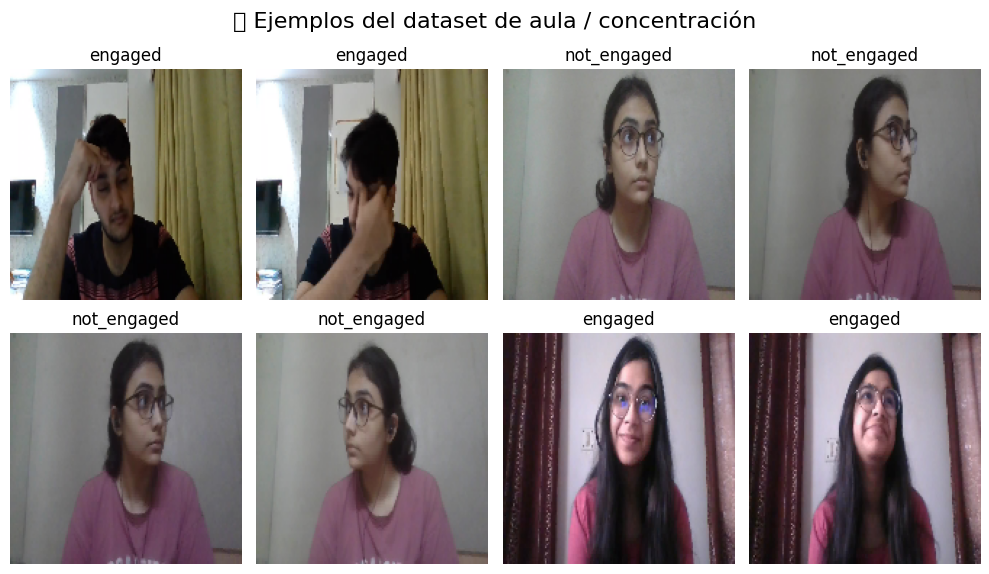

In [6]:
# ============================================================
# 4. Cargar imágenes con image_dataset_from_directory
# ============================================================

IMG_HEIGHT = 160
IMG_WIDTH  = 160
BATCH_SIZE = 32
VAL_SPLIT  = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DATA_DIR,
    labels="inferred",
    label_mode="int",             # etiquetas como enteros (0,1,...)
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DATA_DIR,
    labels="inferred",
    label_mode="int",
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

print("\n🏷️ Clases detectadas:", CLASS_NAMES)
print("Número de clases:", NUM_CLASSES)

# Optimizar el pipeline con cache y prefetch
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Mostrar algunas imágenes de ejemplo
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        etiqueta = CLASS_NAMES[labels[i]]
        plt.title(etiqueta)
        plt.axis("off")
plt.suptitle("👀 Ejemplos del dataset de aula / concentración", fontsize=16)
plt.tight_layout()
plt.show()


In [7]:
# ============================================================
# 5. Definir modelo CNN (Keras Sequential) y entrenar
# ============================================================

# Pequeña capa de aumento de datos (para robustez)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

# Escalado a [0,1]
normalization_layer = layers.Rescaling(1./255)

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_imagen")

x = data_augmentation(inputs)
x = normalization_layer(x)

x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="predicciones")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="modelo_aula_imagenes")

model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS = 20

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,              # si 3 épocas seguidas no mejora val_loss -> para
    restore_best_weights=True,
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop],
)


Model: "modelo_aula_imagenes"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_imagen (InputLayer)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predicciones (Dense)            │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5599 - loss: 1.1300 - val_accuracy: 0.9184 - val_loss: 0.2562
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9406 - loss: 0.2706 - val_accuracy: 0.9541 - val_loss: 0.1964
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9607 - loss: 0.1680 - val_accuracy: 0.9541 - val_loss: 0.1308
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9472 - loss: 0.1591 - val_accuracy: 0.9541 - val_loss: 0.1520
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9669 - loss: 0.1286 - val_accuracy: 0.9745 - val_loss: 0.0817
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9668 - loss: 0.1139 - val_accuracy: 0.9694 - val_loss: 0.0481
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9824 - loss: 0.0558 - val_accuracy: 0.9949 - val_loss: 0.0233
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9867 - loss: 0.0518 - val_accuracy: 0.9541 - val_loss:

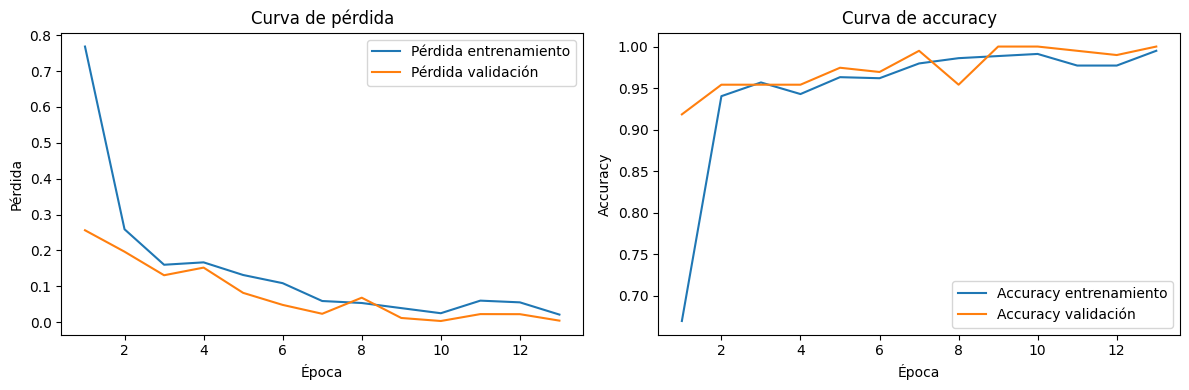

In [8]:
# ============================================================
# 6. Graficar historia de entrenamiento
# ============================================================

hist = history.history

epochs_range = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, hist["loss"], label="Pérdida entrenamiento")
plt.plot(epochs_range, hist["val_loss"], label="Pérdida validación")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Curva de pérdida")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, hist["accuracy"], label="Accuracy entrenamiento")
plt.plot(epochs_range, hist["val_accuracy"], label="Accuracy validación")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Curva de accuracy")
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


/tmp/ipython-input-3594241870.py:27: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


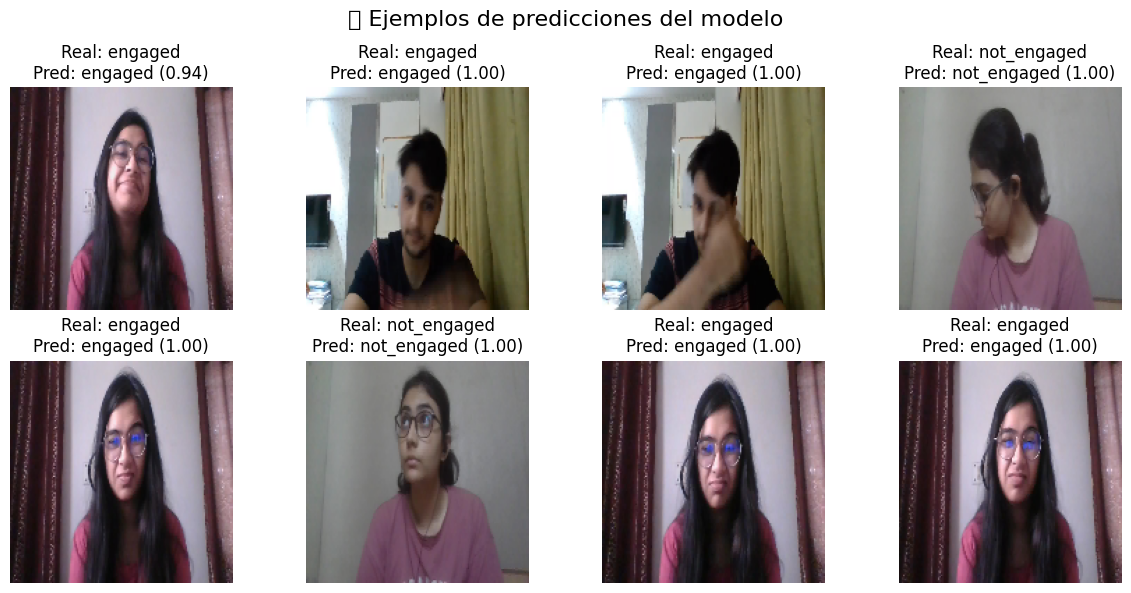


📊 Probabilidades para la imagen 0:
  engaged        : 0.9399
  not_engaged    : 0.0601
Predicción final: engaged


In [9]:
# ============================================================
# 7. Pruebas rápidas del modelo
# ============================================================

# Tomamos un batch de validación
for images_batch, labels_batch in val_ds.take(1):
    images_np = images_batch.numpy()
    labels_np = labels_batch.numpy()
    break

pred_probs = model.predict(images_np)
pred_ids   = np.argmax(pred_probs, axis=1)

plt.figure(figsize=(12, 6))
n_mostrar = min(8, len(images_np))

for i in range(n_mostrar):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images_np[i].astype("uint8"))
    real = CLASS_NAMES[labels_np[i]]
    pred = CLASS_NAMES[pred_ids[i]]
    conf = pred_probs[i][pred_ids[i]]
    plt.title(f"Real: {real}\nPred: {pred} ({conf:.2f})")
    plt.axis("off")

plt.suptitle("🔎 Ejemplos de predicciones del modelo", fontsize=16)
plt.tight_layout()
plt.show()

# También imprimimos las probabilidades de la primera imagen
idx = 0
print("\n📊 Probabilidades para la imagen 0:")
for clase_idx, clase_nombre in enumerate(CLASS_NAMES):
    print(f"  {clase_nombre:15s}: {pred_probs[idx][clase_idx]:.4f}")
print("Predicción final:", CLASS_NAMES[pred_ids[idx]])


In [10]:
# ============================================================
# 8. Guardar el modelo Keras y convertir a TF.js
# ============================================================

import tensorflowjs as tfjs

# Guardar en formato Keras (.keras)
KERAS_MODEL_PATH = Path("/content/modelo_aula_imagenes.keras")
model.save(KERAS_MODEL_PATH)
print("💾 Modelo Keras guardado en:", KERAS_MODEL_PATH)

# Exportar a TF.js
if TFJS_DIR.exists():
    shutil.rmtree(TFJS_DIR)
TFJS_DIR.mkdir(parents=True, exist_ok=True)

tfjs.converters.save_keras_model(model, str(TFJS_DIR))

print("\n📁 Contenido de la carpeta TF.js:")
for p in sorted(TFJS_DIR.iterdir()):
    print(" -", p.name)


💾 Modelo Keras guardado en: /content/modelo_aula_imagenes.keras
failed to lookup keras version from the file,
    this is likely a weight only file

📁 Contenido de la carpeta TF.js:
 - group1-shard1of7.bin
 - group1-shard2of7.bin
 - group1-shard3of7.bin
 - group1-shard4of7.bin
 - group1-shard5of7.bin
 - group1-shard6of7.bin
 - group1-shard7of7.bin
 - model.json


In [19]:
# ============================================================
# 9. Utilidades para "arreglar" el model.json de TF.js
# ============================================================
# Estas funciones corrigen:
#  - Falta de 'batchInputShape' en InputLayer
#  - Prefijos en los nombres de pesos tipo 'sequential/...'

def patch_input_layers(model_json_path: str) -> None:
    """
    Arregla el problema:
      An InputLayer should be passed either a `batchInputShape` or an `inputShape`.

    Copia batch_shape -> batchInputShape si no existe.
    Útil cuando conviertes un modelo Keras a TF.js y TM / tfjs se quejan del InputLayer.
    """
    path = Path(model_json_path)
    data = json.loads(path.read_text(encoding="utf-8"))

    # Distintas estructuras posibles según cómo se exportó el modelo
    topo = data.get("modelTopology") or data.get("model_topology")
    if topo is None:
        print(f"⚠️ No encontré modelTopology en {path}")
        return

    config = topo.get("model_config", {}).get("config", {})
    layers = config.get("layers") or config.get("layer") or []

    changed = False
    for layer in layers:
        if layer.get("class_name") == "InputLayer":
            cfg = layer.get("config", {})
            if "batch_shape" in cfg and "batchInputShape" not in cfg:
                cfg["batchInputShape"] = cfg["batch_shape"]
                changed = True
                print(f"✅ Añadido batchInputShape en InputLayer de {path.name}")

    if changed:
        backup = path.with_suffix(".backup_input.json")
        backup.write_text(json.dumps(data, indent=2), encoding="utf-8")
        path.write_text(json.dumps(data, separators=(",", ":")), encoding="utf-8")
        print(f"💾 Guardado {path} (copia de seguridad: {backup.name})")
    else:
        print(f"ℹ️ No hubo nada que parchear en InputLayer de {path.name}")


def fix_weight_prefix(model_json_path: str, prefix: str) -> None:
    """
    Arregla nombres de pesos del estilo:
      sequential/conv2d_1/kernel  -> conv2d_1/kernel
      sequential_5/dense_10/bias  -> dense_10/bias

    Útil para errores como:
      Provided weight data has no target variable: sequential/.../kernel

    Usas `prefix` = 'sequential', 'sequential_5', etc, según el error que veas.
    """
    path = Path(model_json_path)
    data = json.loads(path.read_text(encoding="utf-8"))

    manifest = data.get("weightsManifest") or data.get("weights_manifest")
    if manifest is None:
        print(f"⚠️ No encontré weightsManifest en {path}")
        return

    changed = False
    for group in manifest:
        for w in group.get("weights", []):
            name = w.get("name", "")
            if name.startswith(prefix + "/"):
                new_name = name.split("/", 1)[1]
                print(f"{name}  ->  {new_name}")
                w["name"] = new_name
                changed = True

    if changed:
        backup = path.with_suffix(".backup_names.json")
        backup.write_text(json.dumps(data, indent=2), encoding="utf-8")
        path.write_text(json.dumps(data, separators=(",", ":")), encoding="utf-8")
        print(f"✅ Parcheado {path} (copia de seguridad: {backup.name})")
    else:
        print(f"ℹ️ No encontré pesos con prefijo '{prefix}' en {path.name}")


def quick_fix_tfjs_model(model_json_path: str, prefixes=None):
    """
    Helper general: le pasas la ruta del model.json y opcionalmente
    una lista de prefijos de pesos a corregir.

    1. Llama a patch_input_layers para asegurar batchInputShape.
    2. Para cada prefijo en 'prefixes', llama a fix_weight_prefix.

    Si tu modelo Keras era Sequential, un prefijo típico es 'sequential'.
    """
    if prefixes is None:
        prefixes = []

    print(f"\n🔧 Arreglando modelo TF.js: {model_json_path}\n")
    patch_input_layers(model_json_path)
    for p in prefixes:
        fix_weight_prefix(model_json_path, p)
    print("\n✅ quick_fix_tfjs_model terminado\n")


In [15]:
# ============================================================
# 10. Aplicar quick_fix_tfjs_model al model.json
# ============================================================

MODEL_JSON_PATH = TFJS_DIR / "model.json"

if not MODEL_JSON_PATH.exists():
    raise FileNotFoundError(f"No se encontró {MODEL_JSON_PATH}. Revisa TFJS_DIR.")

# Intuimos que el prefijo puede ser 'sequential' si el modelo fue Sequential,
# pero como aquí usamos Functional, puede que no haga falta. Igual lo dejamos.
quick_fix_tfjs_model(str(MODEL_JSON_PATH), prefixes=["sequential"])



🔧 Arreglando modelo TF.js: /content/modelo_aula_imagenes_tfjs/model.json

ℹ️ No hubo nada que parchear en InputLayer de model.json
ℹ️ No encontré pesos con prefijo 'sequential' en model.json

✅ quick_fix_tfjs_model terminado



In [16]:
# ============================================================
# 11. Etiquetas en el orden correcto para la web
# ============================================================

print("🏷️ Orden de etiquetas (como las usa el modelo):")
print(CLASS_NAMES)

# También puedes guardarlas en una pequeña lista de Python
labels = CLASS_NAMES
print("\nlabels =", labels)

# En la web (JS) podrías usar algo como:
# const LABELS_IMG = ["focused", "distracted"];  // o lo que salga en CLASS_NAMES


🏷️ Orden de etiquetas (como las usa el modelo):
['engaged', 'not_engaged']

labels = ['engaged', 'not_engaged']


In [17]:
# ============================================================
# 12. Crear un ZIP con el dataset usado para entrenar
# ============================================================

ZIP_NAME = "dataset_aula_imagenes"
ZIP_PATH = Path(f"/content/{ZIP_NAME}.zip")

# Borramos si existe
if ZIP_PATH.exists():
    ZIP_PATH.unlink()

# Crear el zip (contiene /content/dataset_aula_imagenes/...)
shutil.make_archive(
    base_name=str(ZIP_PATH.with_suffix("")),
    format="zip",
    root_dir=str(BASE_DATA_DIR),
)

print("📦 ZIP creado en:", ZIP_PATH)
print("Puedes descargarlo desde el panel de archivos de Colab.")


📦 ZIP creado en: /content/dataset_aula_imagenes.zip
Puedes descargarlo desde el panel de archivos de Colab.
